### Proof of Concept Mini Modeling Approach

In [1]:
# Load in all needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import all Model related packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load in Data
df = pd.read_csv('../data/clean_dataPT2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # Remove unnecessary old index column  

In [3]:
#Check if the loading is correct
df.head()

,Calendar_date,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,...,factor(weather)Snow,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,Season,date,temp,trip_id
0,2022-01-08,41344,1,151,0,0,120,100,100,160,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
1,2022-01-08,41344,2,185,24,171,45,151,100,198,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
2,2022-01-08,41344,3,186,0,55,41,185,100,189,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
3,2022-01-08,41344,4,202,12,42,94,186,100,200,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
4,2022-01-08,41344,5,242,21,98,86,202,100,256,...,0,0,1,0,0,1,Winter,20220108,-0.5,1


In [4]:
# Aggregating the data into the average per day per stop
df_aggregated = df.groupby(['stop_sequence', 'Calendar_date'])[['arrival_delay','scheduled_travel_time', 'dwell_time', 'traffic_condition', 'recurrent_delay', 'origin_delay', 'previous_bus_delay', 'factor(day_of_week)weekday', 'factor(time_of_day)Off-peak', 'temp']].mean()

In [5]:
# Check aggregated data
df_aggregated.head()

arrival_delay  scheduled_travel_time  dwell_time  \
stop_sequence Calendar_date                                                     
1             2022-01-08         55.954545             141.818182         0.0   
              2022-01-09         92.385417             151.250000         0.0   
              2022-01-10         54.518797             175.488722         0.0   
              2022-01-11         38.565217             175.652174         0.0   
              2022-01-12         34.928571             174.642857         0.0   

                             traffic_condition  recurrent_delay  origin_delay  \
stop_sequence Calendar_date                                                     
1             2022-01-08            159.242424       158.968239     32.090909   
              2022-01-09            159.961806       155.480450     68.843750   
              2022-01-10            166.328321       156.923225     42.781955   
              2022-01-11            156.367150       156.353991     30.442029   
              2022-01-12            157.077381       162.680852     30.375000   

                             previous_bus_delay  factor(day_of_week)weekday  \
stop_sequence Calendar_date                                                   
1             2022-01-08              43.636364                         0.0   
              2022-01-09              82.989583                         0.0   
              2022-01-10              32.639098                         1.0   
              2022-01-11              10.659420                         1.0   
              2022-01-12              12.357143                         1.0   

                             factor(time_of_day)Off-peak  temp  
stop_sequence Calendar_date                                     
1             2022-01-08                        1.000000  -0.5  
              2022-01-09                        1.000000  -0.9  
              2022-01-10                        0.526316  -2.3  
              2022-01-11                        0.536232  -1.1  
              2022-01-12                        0.589286   1.3

In [6]:
# Make a version without arrival_delay to not skew PCA
df_aggregated_x = df_aggregated.drop(['arrival_delay'], axis=1)
df_aggregated_y = df_aggregated['arrival_delay']

df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_aggregated_x, df_aggregated_y, test_size=0.2, random_state=42)


In [7]:
# Transformation into Kernel PCA space to uncover non-linear relationships in the data for clustering
scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(df_x_train)
Scaled_data=scaling.transform(df_x_train)
 
# Normal PCA was not revealing use info
""" principal=PCA(n_components=2)
principal.fit(Scaled_data)
x = principal.transform(Scaled_data) """

# Fit Kernel PCA and Transfrom data to KPCA space
k_principal = KernelPCA(n_components=2, kernel='rbf', )
k_principal.fit(Scaled_data)
kpca_data = k_principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(kpca_data.shape)

(3736, 2)


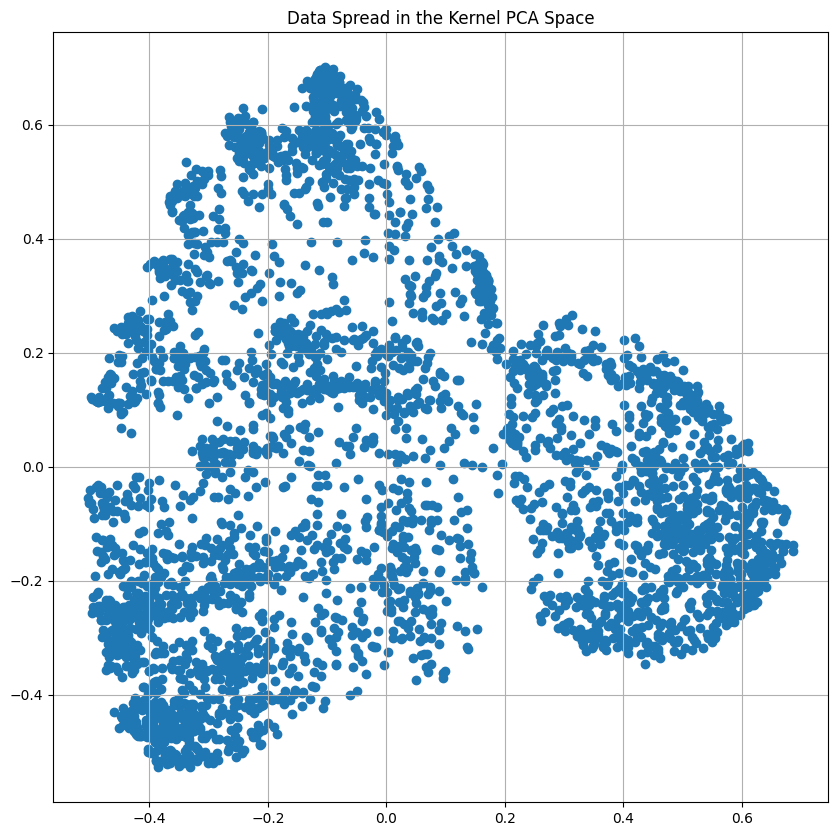

In [8]:
# Visualize the Data in KPCA Space
plt.figure(figsize=(10,10))
plt.grid(True)
plt.title('Data Spread in the Kernel PCA Space')
#TODO: Find our what x and y axis are here
plt.scatter(kpca_data[:,0],kpca_data[:,1])

In [9]:
# Clustering Algorithm runs over KPCA data
clusters = AgglomerativeClustering(n_clusters=6).fit(kpca_data)

if clusters is not None:
    cluster_labels  = clusters.labels_
    #centroids       = clusters.cluster_centers_ 

In [10]:
# Show Metrics for chosen Clustering
print(silhouette_score(kpca_data, cluster_labels), davies_bouldin_score(kpca_data,cluster_labels), calinski_harabasz_score(kpca_data, cluster_labels))

0.39020379804303423 0.9302515883885244 4939.720544314133


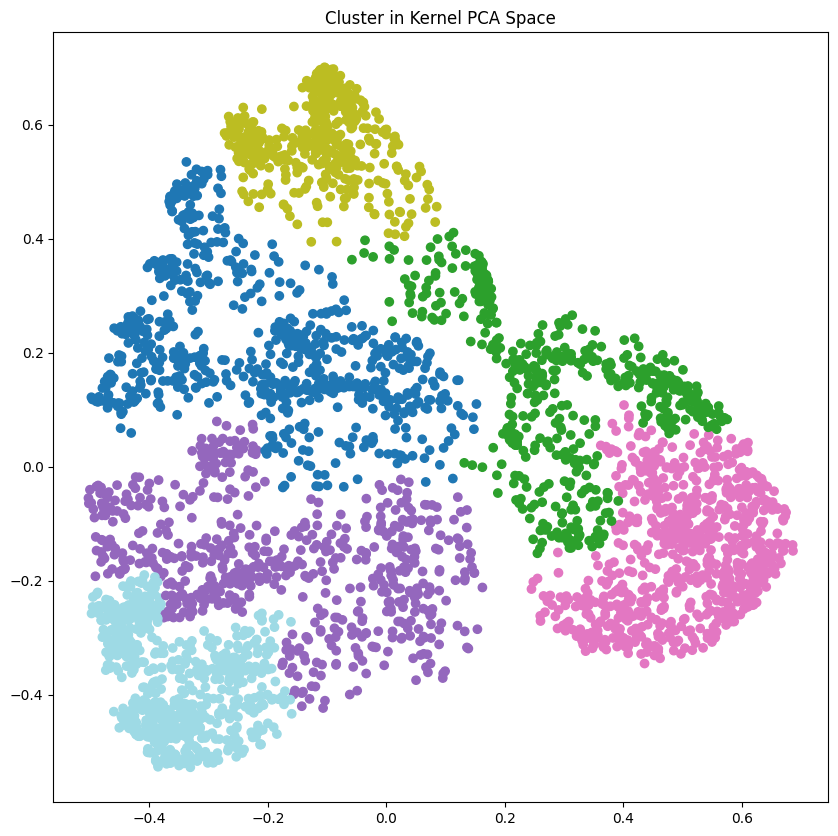

In [11]:
# Visualize Clusters in KPCA space
kpca_clusters = np.zeros([len(kpca_data), 3])
for i in range(0, len(kpca_data)):
    kpca_clusters[i] = (np.append(kpca_data[i], (cluster_labels[i])))

plt.figure(figsize=(10,10))
plt.title('Cluster in Kernel PCA Space')
plt.set_cmap('tab20')
plt.scatter(kpca_clusters[:,0],kpca_clusters[:,1], c=kpca_clusters[:,2])

In [12]:
# Assign clusters to original data
df_x_train['cluster'] = cluster_labels
df_x_train['arrival_delay'] = df_y_train
df_x_train.head()

,,scheduled_travel_time,dwell_time,traffic_condition,recurrent_delay,origin_delay,previous_bus_delay,factor(day_of_week)weekday,factor(time_of_day)Off-peak,temp,cluster,arrival_delay
stop_sequence,Calendar_date,,,,,,,,,,,
25,2022-04-06,59.448980,32.632653,44.414966,44.500032,62.258503,139.231293,1.0,0.503401,1.1,5,173.401361
5,2022-05-28,111.008850,40.902655,97.383481,106.087002,45.707965,76.637168,0.0,1.000000,8.5,1,85.247788
14,2022-02-13,124.278351,37.329897,93.309278,94.284308,127.010309,261.103093,0.0,1.000000,2.1,1,269.670103
9,2022-02-10,65.631944,60.125000,39.587963,41.071952,56.208333,124.125000,1.0,0.506944,2.3,5,127.868056
2,2022-03-28,81.760563,66.422535,51.948357,51.926769,48.246479,67.563380,1.0,0.492958,7.8,2,74.281690


In [13]:
# Check if any clusters are to small to train a model on
df_x_train['cluster'].value_counts()

cluster
3    767
0    688
5    665
2    634
1    542
4    440
Name: count, dtype: int64

In [14]:
# Make list of dictionaries for data frames which each represents all data entries in a specific cluster.
cluster_nums = np.sort(df_x_train['cluster'].unique())
split_dataframes = []
for i in cluster_nums:
    key_name = 'df_cluster_' + str(i)
    spilt_dict = {
        'id':   key_name,
        'data': df_x_train[df_x_train['cluster'] == i],
        'model': None,
        'performance': None
        }
    split_dataframes.append(spilt_dict)

In [15]:
split_dataframes[0]['data'].head()

scheduled_travel_time  dwell_time  \
stop_sequence Calendar_date                                      
8             2022-04-01                139.235714   24.564286   
11            2022-04-20                127.930070   24.664336   
17            2022-04-28                 99.625000   72.694444   
24            2022-03-18                129.458333   17.263889   
              2022-02-16                129.482759   18.613793   

                             traffic_condition  recurrent_delay  origin_delay  \
stop_sequence Calendar_date                                                     
8             2022-04-01             91.254762        89.338171     78.564286   
11            2022-04-20             82.114219        77.980539     68.818182   
17            2022-04-28             86.011574        81.903697    116.333333   
24            2022-03-18             84.569444        85.691146     50.062500   
              2022-02-16             86.222989        85.554285     66.875862   

                             previous_bus_delay  factor(day_of_week)weekday  \
stop_sequence Calendar_date                                                   
8             2022-04-01             110.228571                         1.0   
11            2022-04-20             142.643357                         1.0   
17            2022-04-28             250.666667                         1.0   
24            2022-03-18              76.506944                         1.0   
              2022-02-16             119.400000                         1.0   

                             factor(time_of_day)Off-peak  temp  cluster  \
stop_sequence Calendar_date                                               
8             2022-04-01                        0.514286  -1.4        0   
11            2022-04-20                        0.517483   8.5        0   
17            2022-04-28                        0.500000   6.7        0   
24            2022-03-18                        0.520833   5.1        0   
              2022-02-16                        0.503448   2.0        0   

                             arrival_delay  
stop_sequence Calendar_date                 
8             2022-04-01        135.971429  
11            2022-04-20        150.902098  
17            2022-04-28        254.118056  
24            2022-03-18        142.180556  
              2022-02-16        169.848276

In [17]:
# Essential Loop that trains a model for each subset. Performance and model are saved to the list of to dicts created above.
all_test        = []
all_predicted   = []

for sub_set in split_dataframes:
    # Data Preparation
    x = sub_set['data'].drop(['cluster', 'arrival_delay'], axis=1)
    y = sub_set['data']['arrival_delay']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Grid Search for Best Parameters
    params = {
                'learning_rate': [0.01, 0.1, 0.2],
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5]
            }

    grid_search = GridSearchCV(GradientBoostingRegressor(), params, cv=5, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print('Best Parameters for ' + sub_set['id'] + ': ' + str(best_params))

    # Evaluation of Model Performance
    best_model = GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
    cv_scores = cross_val_score(best_model, x , y, cv=5, verbose=0).mean()
    print('CV Score Mean for ' + sub_set['id'] + ' : ' + str(cv_scores))

    best_model.fit(x_train, y_train)

    y_pred = best_model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save model metrics
    sub_set['model'] = best_model
    sub_set['performance'] = {
        'mae':  mae,
        'mse':  mse,
        'r2':   r2, 
        'cross_val':    cv_scores
    }

    all_test =      [*all_test, *y_test]
    all_predicted = [*all_predicted, *y_pred]

Best Parameters for df_cluster_0: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
CV Score Mean fordf_cluster_0 : 0.9323775162908993
Best Parameters for df_cluster_1: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
CV Score Mean fordf_cluster_1 : 0.9771326981205022
Best Parameters for df_cluster_2: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
CV Score Mean fordf_cluster_2 : 0.9148676245123355
Best Parameters for df_cluster_3: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
CV Score Mean fordf_cluster_3 : 0.9813215455152575
Best Parameters for df_cluster_4: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
CV Score Mean fordf_cluster_4 : 0.8486883809117476
Best Parameters for df_cluster_5: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
CV Score Mean fordf_cluster_5 : 0.9303888109582396


In [18]:
# Make data frame showing performance indicators of individual models
performance_list = list(map(lambda a: a['performance'], split_dataframes))
df_performance = pd.DataFrame(performance_list)
df_performance

,mae,mse,r2,cross_val
0,5.589675,67.535985,0.972455,0.932378
1,8.639287,156.588648,0.983650,0.977133
2,10.702776,405.356156,0.888394,0.914868
3,5.365014,72.191806,0.985823,0.981322
4,5.852257,66.081249,0.956805,0.848688
5,5.438526,114.892992,0.943268,0.930389


In [19]:
len(all_predicted)

749

In [20]:
len(all_test)

749

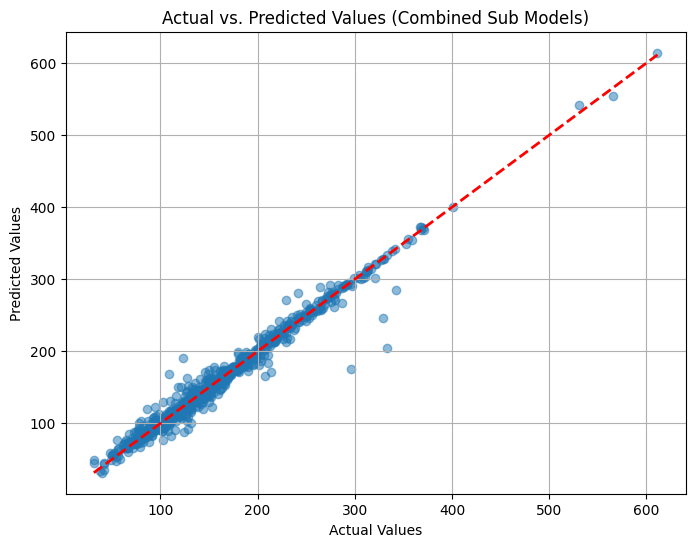

In [21]:
# Create a scatter plot for actual vs predicted values for the trainings data of the individual sub models
plt.figure(figsize=(8, 6))
plt.scatter(all_test, all_predicted, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Combined Sub Models)")
plt.grid(True)

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(all_test), max(all_test)], [min(all_test), max(all_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

In [22]:
import sklearn.metrics.pairwise as dis_lib

In [23]:
# Copied from Lab 5 :)
# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances([centroids[i]], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

In [26]:
from sklearn.neighbors import NearestCentroid

centroid_model = NearestCentroid().fit(kpca_data, cluster_labels)

In [36]:
def predict_with_mini_model(data_point, scaler, kernel_pca, centroid_model, list_subsets):
    # Transform data point into kpca space and get its closest centroid
    data_point = data_point.copy()
    scaled_dp   = scaler.transform(data_point)
    kpca_dp     = kernel_pca.transform(scaled_dp)

    # Get closest centroid to data point
    cluster_label = centroid_model.predict(kpca_dp)

    #data_point['cluster'] = cluster_label

    # Predict  the arrival using that clusters sub model
    arrival_delay_dp = list_subsets[cluster_label[0]]['model'].predict(data_point)

    return arrival_delay_dp
    

In [84]:
# Single point Testing
test_dp = df_aggregated.sample(n=1, random_state=0).copy()
print(test_dp['arrival_delay'])

stop_sequence  Calendar_date
3              2022-02-14       79.636986
Name: arrival_delay, dtype: float64


In [85]:
test_dp_input = test_dp[['scheduled_travel_time', 'dwell_time', 'traffic_condition', 'recurrent_delay', 'origin_delay', 'previous_bus_delay', 'factor(day_of_week)weekday', 'factor(time_of_day)Off-peak', 'temp']]

In [86]:
test_arrival_delay = predict_with_mini_model(test_dp_input, scaling, k_principal, centroid_model, split_dataframes)

In [87]:
test_arrival_delay

array([77.2836484])

In [66]:
# Get all 
predicted_values = []
for index, row in df_x_test.iterrows():
    input_point = row[['scheduled_travel_time', 'dwell_time', 'traffic_condition', 'recurrent_delay', 'origin_delay', 'previous_bus_delay', 'factor(day_of_week)weekday', 'factor(time_of_day)Off-peak', 'temp']]
    predicted_values.append(predict_with_mini_model([input_point], scaling, k_principal, centroid_model, split_dataframes))

c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings

In [73]:
mae = mean_absolute_error(df_y_test.values, predicted_values)
mse = mean_squared_error(df_y_test.values, predicted_values)
r2 = r2_score(df_y_test.values, predicted_values)

print(mae, mse, r2)

7.558187360404178 178.71251627227608 0.9685248555805881


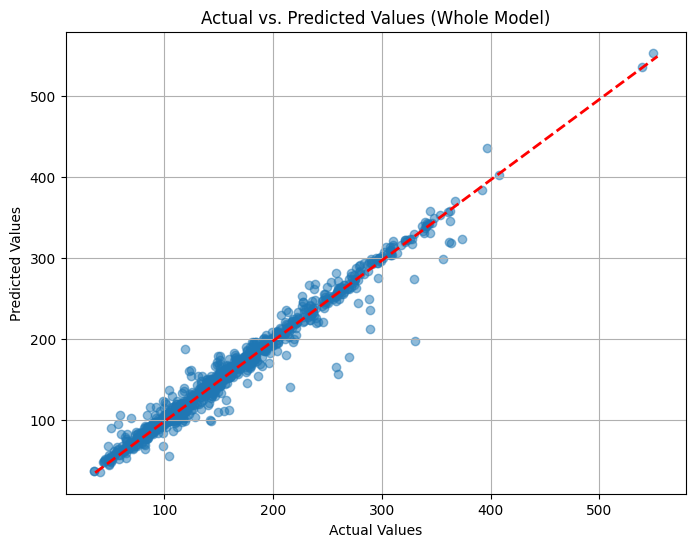

In [89]:
# Create a scatter plot for actual vs predicted values for the trainings data of the individual sub models
plt.figure(figsize=(8, 6))
plt.scatter(df_y_test.values, predicted_values, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Whole Model)")
plt.grid(True)

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(predicted_values), max(predicted_values)], [min(df_y_test.values), max(df_y_test.values)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()